https://levelup.gitconnected.com/how-i-tripled-my-return-on-bitcoin-using-mathematics-algorithms-and-python-347edd9b5625

In [1]:
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.CRITICAL)

In [2]:
class Trader:
    def __init__(self, symbol='eth', account_size=100, margin=0.1, fixed_margin=False, leverage=1, fee=0.0004):
        """
        Account size : int
        - Money in the account
        
        Margin : float [0, 1]
        - Percentage of account size for each trade
        
        fixed_margin : bool
        - use fixed margin for each trade
        - True : each trade use initial account size * margin
        - False : each trade use current account size * margin
        
        leverage : int
        
        fee : float
        """
        
        if (margin > 1) or (margin < 0):
            raise Exception('Margin between 0 and 1')
        
        self.symbol = symbol
        self.initial_account_size = account_size
        self._margin = margin
        self.account_size = account_size
        self.leverage = leverage
        self.fixed_margin = fixed_margin
        self.fee = fee
        self.history = []
        self.cache = {
            'entry_price': None,
            'position' : None, # long=1 / short=-1
            'entry_margin' : None
        }
        
    @property
    def margin(self):
        if self.fixed_margin:
            return self.initial_account_size * self._margin
        else:
            return self.account_size * self._margin
        
    @property
    def position(self):
        return self.cache['position']
    
    @position.setter
    def position(self, value):
        if (value == 'long') | (value == 'short') | (value == None):
            self.cache['position'] = value
        else:
            raise Exception('Enter long / short')
        
    @property
    def entry_price(self):
        return self.cache['entry_price']
    
    @entry_price.setter
    def entry_price(self, value):
        self.cache['entry_price'] = value
        
    @property
    def exit_price(self):
        return self.cache['exit_price']
        
    @property
    def entry_margin(self):
        return self.cache['entry_margin']
    
    @entry_margin.setter
    def entry_margin(self, value):
        self.cache['entry_margin'] = value
        
    def reset(self):
        logging.info('Resetting...')
        self.cache = {
            'entry_price': None,
            'position' : None,
            'entry_margin' : None,
        }
        self.history = []
        self.account_size = self.initial_account_size
        
    def _clear_cache(self):
        self.cache = {
            'entry_price': None,
            'position' : None,
            'entry_margin' : None,
        }
        
    def open_pos(self, price, position, **kwargs):
        """
        1. Get entry price and position
        2. Get other entry information
        3. Compute trade size / notional size (leverage * margin)
        4. Compute Fee (trade size * fee)
        5. Fee reduction
        """
        if self.position != None:
            raise Exception('Has an opening position')
            
        self.entry_price = price
        self.position = position
        self.entry_margin = self.margin
        number_contract = self._compute_number_contract(price)
        fee = self._deduct_fee()
        self._update_cache(entry_fee=fee, number_contract=number_contract, **kwargs)
        logging.info('Enter {position} - price : {price} | size : {size}{symbol}'.format(position=self.position, 
                                                                                         price=price,
                                                                                         size=number_contract,
                                                                                         symbol=self.symbol))

    def close_pos(self, exit_price, **kwargs):
        if (self.position != 'long') & (self.position != 'short'):
            raise Exception('No position')
            
        percentage = self.get_percentage(self.entry_price, exit_price, self.position)
        self._update_account_size(percentage)
        fee = self._deduct_fee()
        self._update_cache(exit_price=exit_price, profit=self.entry_margin * percentage, percentage=percentage, exit_fee=fee, account_size=self.account_size, **kwargs)
        self._append_history()
        logging.info('Close {position} - price : {price} | percentage(%) : {percentage}'.format(position=self.position, 
                                                                                                price=exit_price, 
                                                                                                percentage=percentage*100))
        self._clear_cache()
    
    def get_liquidation_price(self):
        side1both = 1 if self.position == 'long' else -1
        position1both = self.cache['number_contract']
        ep1both = self.entry_price
        mmrb = 0.005
        return (self.account_size - side1both * position1both * ep1both) / (position1both * mmrb - side1both * position1both)
        
    def is_liquidated(self, price):
        if self.position == None:
            raise Exception('No position')
        
        if self.position == 'long':
            return price <= self.get_liquidation_price()
        elif self.position == 'short':
            return price >= self.get_liquidation_price()
        
    def _get_fee(self):
        return self.entry_margin * self.leverage * self.fee

    def _deduct_fee(self):
        fee = self._get_fee()
        self.account_size -= fee
        return fee
    
    def _compute_number_contract(self, price):
        return (self.entry_margin * self.leverage) / price
    
    def get_percentage(self, entry, exit, position):
        if position == None:
            raise Exception('No position')
            
        if position == 'long':
            return (exit - entry) / entry * self.leverage
        elif position == 'short':
            return (entry - exit) / entry * self.leverage
            
            
    def _update_account_size(self, percentage):
        self.account_size += self.entry_margin * percentage 
    
    def _update_cache(self, **kwargs):
        for kwarg in kwargs:
            self.cache[kwarg] = kwargs[kwarg]
    
    def _append_history(self):
        self.history.append(self.cache)

In [8]:
short = np.arange(5, 50)
long = np.arange(50, 200)

trader = Trader()
history = []
for i in short:
    print()
    print('i={:d}'.format(i))
    for idx2, j in enumerate(long):
        print('\rj={:d} | {:.2f}%'.format(j, idx2 / (len(long) + 1) * 100), end='')
        
        data_paths = [
            'data/2022/january/ethusdt.4hour.1january2022-1february2022.csv',
            'data/2022/february/ethusdt.4hour.1-28feb2022.csv',
            'data/2022/march/ethusdt.4hour.1march2022-18march2022.csv'
        ]

        df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
        df = df.drop_duplicates(keep='first')

        df = df.assign(short_ema=talib.EMA(df.Close, timeperiod=i))
        df = df.assign(long_ema=talib.EMA(df.Close, timeperiod=j))
        df = df.dropna()

        df.index = pd.to_datetime(df.index)
        df = df.sort_values('Open time')
        # df = df[(df.index.year == 2022) * (df.index.month >= 2)]
        df = df[df.index.month >= 2]

        trader = Trader(leverage=10, margin=0.1, fixed_margin=True)

        previous_shortema = df.iloc[0].short_ema
        previous_longema = df.iloc[0].long_ema
        
        trader.reset()
        for idx, data in df.iloc[1:].iterrows():
            if (previous_shortema < previous_longema) & (data.short_ema > data.long_ema): # golden cross / long
                if trader.position != None: # exit & enter long
                    trader.close_pos(data.Close, 
                                     exit_shortema = data.short_ema,
                                     exit_longema = data.long_ema,
                                     exit_previous_shortema = previous_shortema,
                                     exit_previous_longema = previous_longema)
                    trader.open_pos(data.Close, 'long', 
                                    entry_shortema = data.short_ema,
                                    entry_longema = data.long_ema,
                                    entry_previous_shortema = previous_shortema,
                                    entry_previous_longema = previous_longema)
                else:
                    trader.open_pos(data.Close, 'long', 
                                    entry_shortema = data.short_ema,
                                    entry_longema = data.long_ema,
                                    entry_previous_shortema = previous_shortema,
                                    entry_previous_longema = previous_longema)

            elif (previous_shortema > previous_longema) & (data.short_ema < data.long_ema): # death cross / short
                if trader.position != None: # exit & enter short
                    trader.close_pos(data.Close, 
                                     exit_shortema = data.short_ema,
                                     exit_longema = data.long_ema,
                                     exit_previous_shortema = previous_shortema,
                                     exit_previous_longema = previous_longema)
                    trader.open_pos(data.Close, 'short', 
                                    entry_shortema = data.short_ema,
                                    entry_longema = data.long_ema,
                                    entry_previous_shortema = previous_shortema,
                                    entry_previous_longema = previous_longema)
                else:
                    trader.open_pos(data.Close, 'short', 
                                    entry_shortema = data.short_ema,
                                    entry_longema = data.long_ema,
                                    entry_previous_shortema = previous_shortema,
                                    entry_previous_longema = previous_longema)

            previous_shortema = data.short_ema
            previous_longema = data.long_ema
        history.append([i, j, trader.account_size])
    print('Maximum percentage = ', np.max(np.array(history)[:, 2]))


i=5
j=199 | 98.68%Maximum percentage =  84.1639199538243

i=6
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=7
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=8
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=9
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=10
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=11
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=12
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=13
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=14
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=15
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=16
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=17
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=18
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=19
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=20
j=199 | 98.68%Maximum percentage =  87.6601320939638

i=21
j=199 | 98.68%Maximum percentage =  87.6601320939638

i

In [9]:
df_history = pd.DataFrame(history, columns=['i','j','percentage'])
df_history[df_history.percentage > 100].sort_values('percentage', ascending=False).head(50)

,i,j,percentage


In [111]:
df_klines = pd.read_csv('ethusdt.5min.1-8march2022.csv', index_col='Open time')

df = df_klines[['Open', 'High', 'Low', 'Close', 'Volume']]

In [112]:
short = 49
long = 127

trader = Trader()
history = []
        
df = df_klines[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.assign(short_ema=talib.EMA(df.Close, timeperiod=i), 
               long_ema=talib.EMA(df.Close, timeperiod=j))
df = df.dropna()

previous_shortema = df.iloc[0].short_ema
previous_longema = df.iloc[0].long_ema

trader.reset()
for idx, data in df.iloc[1:].iterrows():
    if (previous_shortema < previous_longema) & (data.short_ema > data.long_ema): # golden cross / long
        if trader.position != None: # exit & enter long
            trader.close_pos(data.Close, 
                             exit_shortema = data.short_ema,
                             exit_longema = data.long_ema,
                             exit_previous_shortema = previous_shortema,
                             exit_previous_longema = previous_longema,
                             date = idx)
            trader.open_pos(data.Close, 'long', 
                            entry_shortema = data.short_ema,
                            entry_longema = data.long_ema,
                            entry_previous_shortema = previous_shortema,
                            entry_previous_longema = previous_longema,
                            date = idx)
        else:
            trader.open_pos(data.Close, 'long', 
                            entry_shortema = data.short_ema,
                            entry_longema = data.long_ema,
                            entry_previous_shortema = previous_shortema,
                            entry_previous_longema = previous_longema,
                            date = idx)

    elif (previous_shortema > previous_longema) & (data.short_ema < data.long_ema): # death cross / short
        if trader.position != None: # exit & enter short
            trader.close_pos(data.Close, 
                             exit_shortema = data.short_ema,
                             exit_longema = data.long_ema,
                             exit_previous_shortema = previous_shortema,
                             exit_previous_longema = previous_longema,
                             date = idx)
            trader.open_pos(data.Close, 'short', 
                            entry_shortema = data.short_ema,
                            entry_longema = data.long_ema,
                            entry_previous_shortema = previous_shortema,
                            entry_previous_longema = previous_longema,
                            date = idx)
        else:
            trader.open_pos(data.Close, 'short', 
                            entry_shortema = data.short_ema,
                            entry_longema = data.long_ema,
                            entry_previous_shortema = previous_shortema,
                            entry_previous_longema = previous_longema,
                            date = idx)

    previous_shortema = data.short_ema
    previous_longema = data.long_ema


In [116]:
df

,Open,High,Low,Close,Volume,short_ema,long_ema
Open time,,,,,,,
2022-03-01 16:30:00,2944.46,2944.90,2911.02,2917.79,30018.054,2958.230380,2929.180804
2022-03-01 16:35:00,2917.79,2929.85,2910.00,2926.01,18593.985,2956.941565,2929.149096
2022-03-01 16:40:00,2926.01,2933.64,2922.00,2927.37,9688.119,2955.758702,2929.131305
2022-03-01 16:45:00,2927.53,2927.59,2906.56,2912.63,13844.575,2954.033554,2928.966292
2022-03-01 16:50:00,2912.63,2914.51,2902.00,2906.14,19159.530,2952.117812,2928.738029
...,...,...,...,...,...,...,...
2022-03-07 23:40:00,2511.74,2511.74,2505.91,2508.14,2852.603,2501.374839,2534.824243
2022-03-07 23:45:00,2508.05,2508.20,2484.00,2489.91,12502.858,2500.916245,2534.375101
2022-03-07 23:50:00,2489.91,2494.53,2488.84,2494.52,7326.281,2500.660395,2533.976550


In [113]:
df_tmp = pd.DataFrame(trader.history).set_index('date')

In [114]:
df_tmp

,entry_price,position,entry_shortema,entry_longema,entry_previous_shortema,entry_previous_longema,exit_price,percentage,margin,exit_shortema,exit_longema,exit_previous_shortema,exit_previous_longema
date,,,,,,,,,,,,,
2022-03-02 03:30:00,2922.22,short,2941.544355,2941.654477,2942.349537,2941.850785,2958.54,0.987571,98.757109,2941.535757,2941.517606,2940.827247,2941.345663
2022-03-02 14:20:00,2958.54,long,2941.535757,2941.517606,2940.827247,2941.345663,2954.39,0.998597,98.618581,2971.878807,2972.382347,2972.607507,2972.564088
2022-03-02 14:40:00,2954.39,short,2971.878807,2972.382347,2972.607507,2972.564088,3025.25,0.976015,96.253249,2972.734880,2972.555022,2970.546750,2972.022750
2022-03-02 15:55:00,3025.25,long,2972.734880,2972.555022,2970.546750,2972.022750,2952.09,0.975817,93.925545,2972.130766,2972.715708,2972.965798,2972.924049
2022-03-05 11:25:00,2952.09,short,2972.130766,2972.715708,2972.965798,2972.924049,2650.27,1.102239,103.528439,2641.948145,2641.730959,2641.601401,2641.644706
2022-03-05 15:45:00,2650.27,long,2641.948145,2641.730959,2641.601401,2641.644706,2639.78,0.996042,103.118664,2642.929661,2642.999670,2643.060897,2643.032192
2022-03-05 16:20:00,2639.78,short,2642.929661,2642.999670,2643.060897,2643.032192,2647.42,0.997106,102.820220,2643.050839,2643.022373,2642.868790,2642.977952
2022-03-06 04:00:00,2647.42,long,2643.050839,2643.022373,2642.868790,2642.977952,2622.99,0.990772,101.871410,2656.186834,2656.678798,2657.570035,2657.019089
2022-03-07 13:45:00,2622.99,short,2656.186834,2656.678798,2657.570035,2657.019089,2620.64,1.000896,101.962679,2556.648655,2555.305089,2553.982349,2554.645141


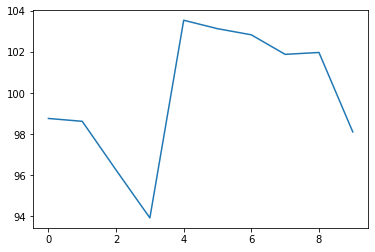

In [115]:
plt.plot(df_tmp.margin.values)